##### **IMPORT LIBRARIES, SET SEED AND DEFINE IMPORTANT VARIABLES**

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
from PIL import Image
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

SEED = 7
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_PATH = "./Dataset/Dataset2B"
train_directory = os.path.join(DATASET_PATH, "train")
val_directory = os.path.join(DATASET_PATH, "val")
test_directory = os.path.join(DATASET_PATH, "test")
i_size = (224, 224)
b_size = 8

print("All libraries imported.")

All libraries imported.


#### **DATA SPLITTING AND EXPLORATORY DATA ANALYSIS**

##### **SPLIT (TRAIN AND VAL)**

In [2]:
val_split = 0.15

for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        images = os.listdir(class_directory)
        train_i, val_i = train_test_split(images,
                                          test_size = val_split,
                                          random_state = SEED)
        val_class_dir = os.path.join(val_directory, 
                                     c_name)
        os.makedirs(val_class_dir, 
                    exist_ok = True)
    
        for image in val_i:
            source = os.path.join(class_directory, 
                                  image)
            dest = os.path.join(val_class_dir, 
                                image)
            shutil.move(source, dest)

print("Training and validation data splitted.")

Training and validation data splitted.


#### **EDA**

> In this section, I will conduct preliminary exploration of the training data to:
> 1. Check Data Balance: verify whether the dataset is balanced across classes.
> 2. Analyze Image Characteristics: generate histograms to visualize color distributions, aspect ratios, resolution patterns, variability across samples, data quality control, also identify and handle any corrupted or unreadable image files.
> 
> This initial analysis will help establish a foundational understanding of the dataset's composition and quality before proceeding with model development.

##### **CLASS DISTRIBUTION**

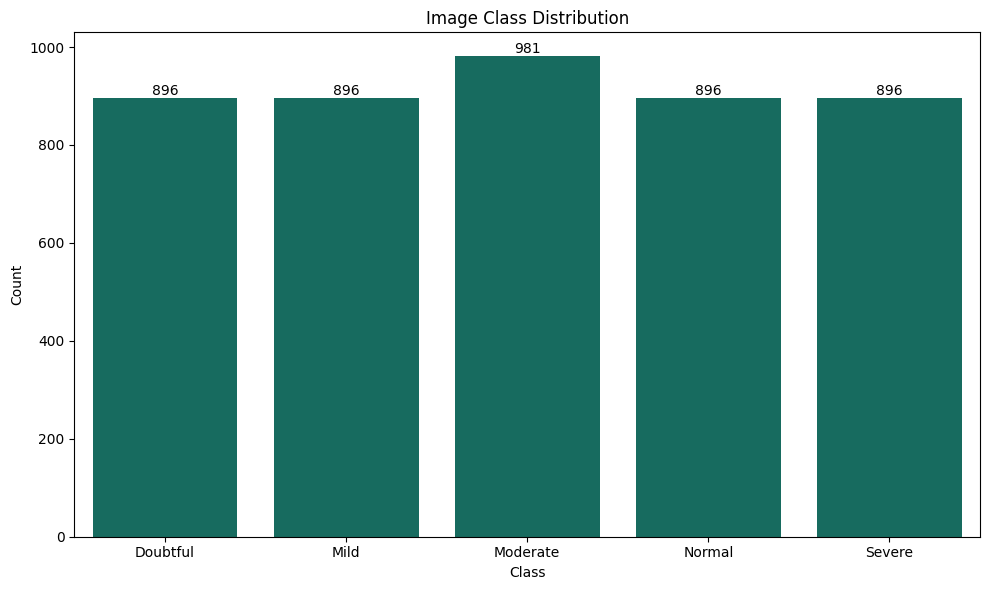

In [3]:
def class_distribution(directory):
    class_counts = {}
    for c_name in os.listdir(directory):
        class_directory = os.path.join(directory, 
                                       c_name)
        if os.path.isdir(class_directory):
            class_counts[c_name] = len(os.listdir(class_directory))

    plt.figure(figsize = (10, 6))
    ax = sns.barplot(x = list(class_counts.keys()),
                     y = list(class_counts.values()),
                     color = "#097969")
    plt.title("Image Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.5,
            f"{int(p.get_height())}",
            ha = "center",
            va = "bottom"
        )
        
    plt.tight_layout()
    plt.show()

class_distribution(train_directory)

> Based on the output above, we can observe that the provided Osteoarthritis medical images are divided into 5 main classes: Doubtful, Mild, Moderate, Normal, and Severe.  
> The distribution of images per class in the training data is relatively balanced, as most classes fall within a similar range. However, the Moderate class contains approximately 100 more images compared to the others.

##### **DISPLAY RANDOM IMAGE**

In [4]:
c_names = os.listdir(train_directory)

def view_random_image(directory, class_name):
    plt.figure(figsize = (9, 6))
    class_directory = os.path.join(directory, 
                                   class_name)
    random_image = random.sample(os.listdir(class_directory), 1)
    img = mpimg.imread(os.path.join(class_directory, random_image[0]))
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
    return img

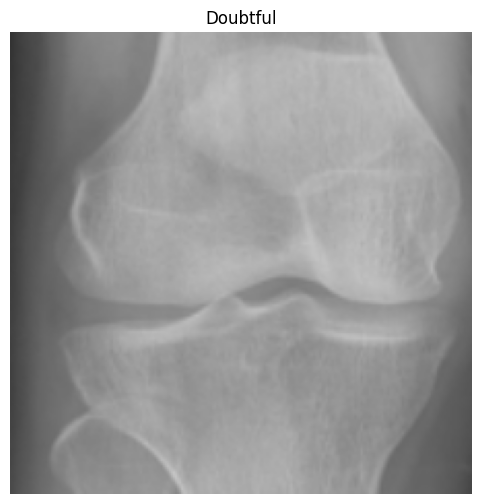

In [5]:
r_image = view_random_image(train_directory, 
                            c_names[0])

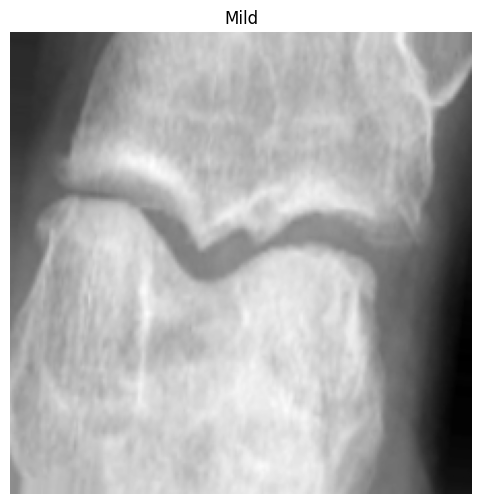

In [6]:
r_image = view_random_image(train_directory, 
                            c_names[1])

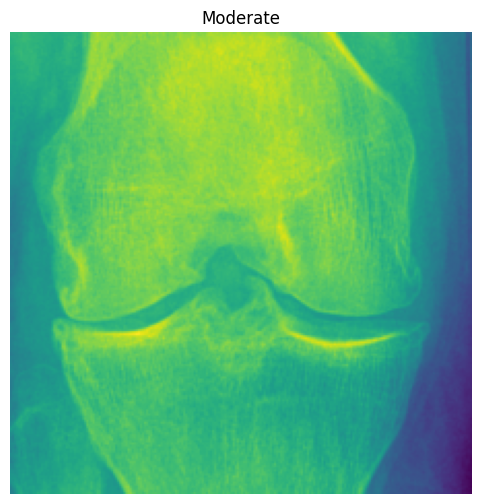

In [7]:
r_image = view_random_image(train_directory, 
                            c_names[2])

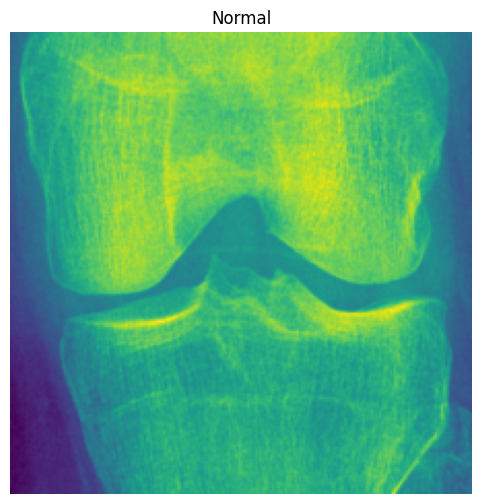

In [8]:
r_image = view_random_image(train_directory, 
                            c_names[3])

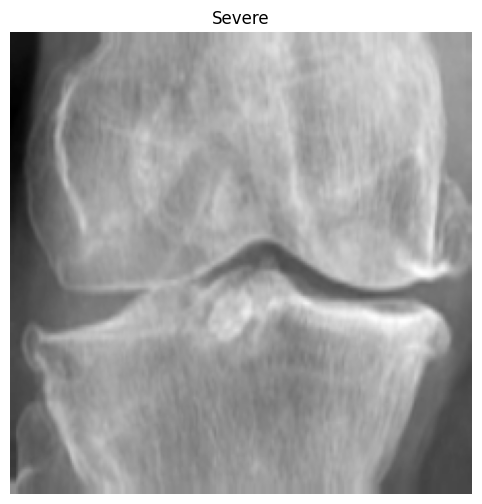

In [9]:
r_image = view_random_image(train_directory, 
                            c_names[4])

> Based on the output above, the data from the *Dataset2B* folder can be read successfully without any issues.

##### **COLOR HISTOGRAM**

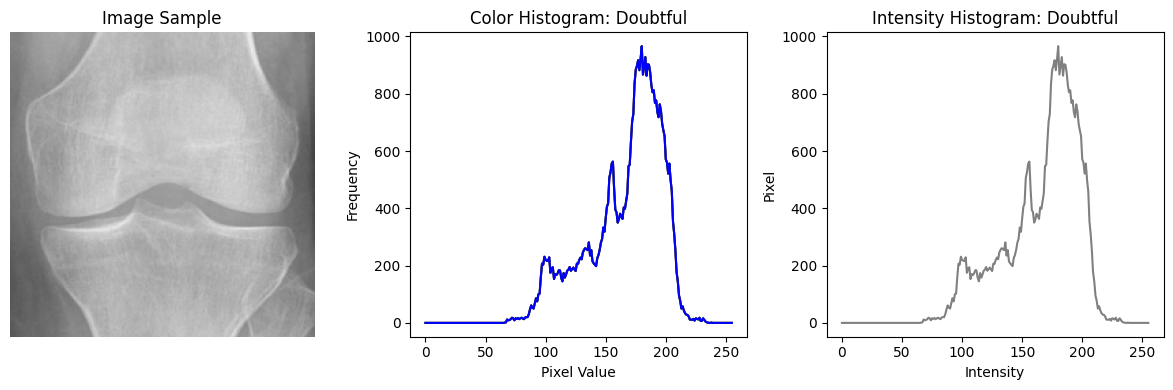

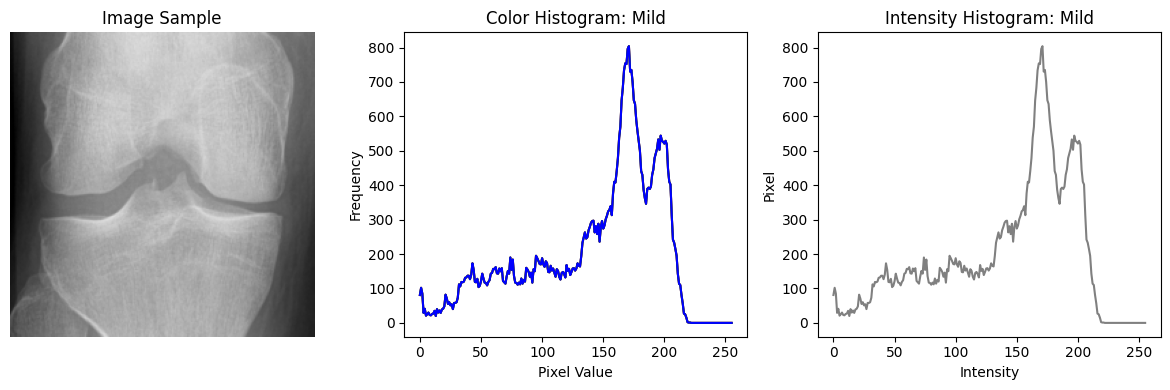

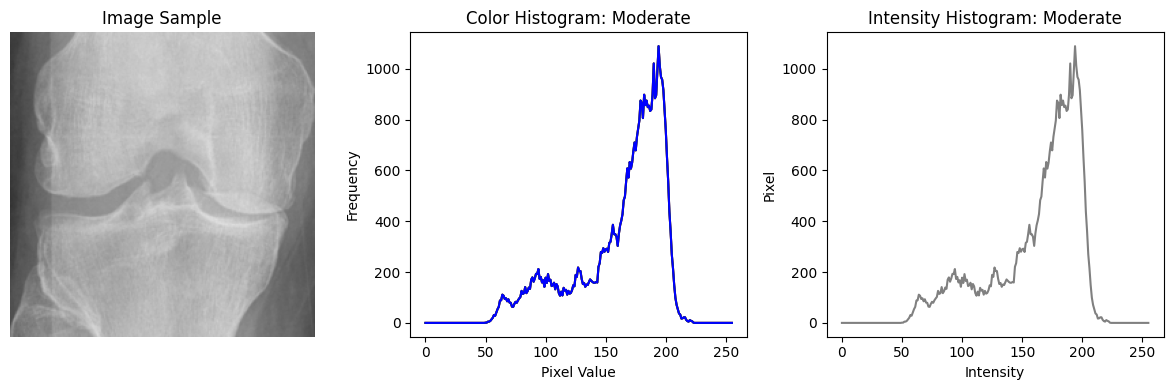

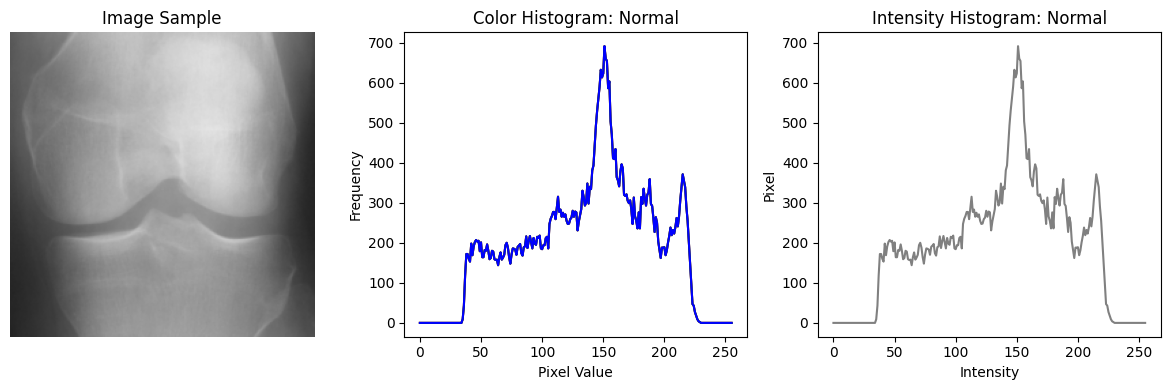

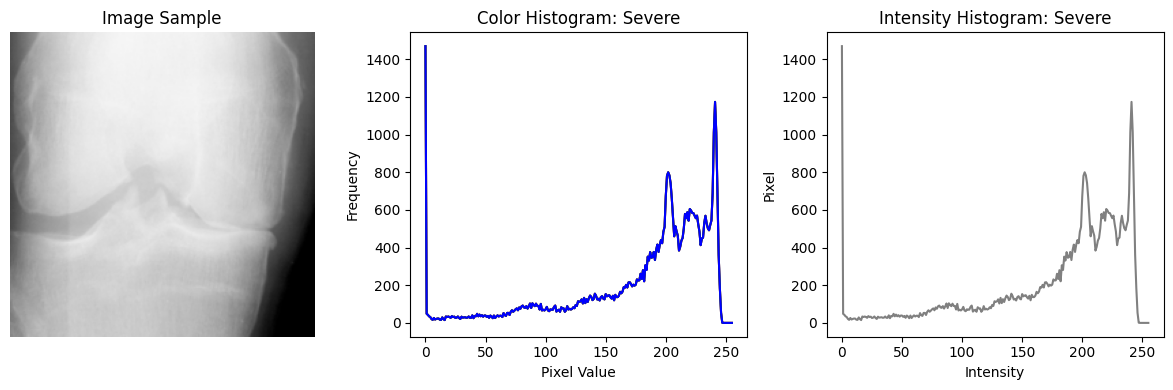

In [10]:
def color_hist(i_path, c_name):
    image = Image.open(i_path).convert("RGB").resize(i_size)
    plt.figure(figsize = (12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image Sample")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    colors = ("red", "green", "blue")
    for i, color in enumerate(colors):
        hist, bins = np.histogram(np.array(image)[:, :, i], 
                                  bins = 256,
                                  range = (0, 256))
        plt.plot(hist, 
                 color = color)
    plt.title(f"Color Histogram: {c_name}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 3)
    image_gs = image.convert("L")
    hist_gs, bins = np.histogram(np.array(image_gs), 
                                 bins = 256,
                                 range = (0, 256))
    plt.title(f"Intensity Histogram: {c_name}")
    plt.xlabel("Intensity")
    plt.ylabel("Pixel")
    plt.plot(hist_gs,
             color = "gray")
    plt.tight_layout()
    plt.show()

for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        sample_image = os.listdir(class_directory)[0]
        i_path = os.path.join(class_directory,
                              sample_image)
        color_hist(i_path,
                   c_name)

> The plot above confirms that the dataset consists of grayscale images, as evidenced by the color histogram displaying only a single color channel. This aligns with the expected characteristics of X-ray bone images, which are typically monochromatic.
> To ensure data consistency, I converted all images to grayscale format. The intensity distribution from sample images across each class shows:
> - 0 intensity: Black pixels
> - 255 intensity: White pixels

##### **ASPECT RATIO PLOT AND UNIQUE RESOLUTION**

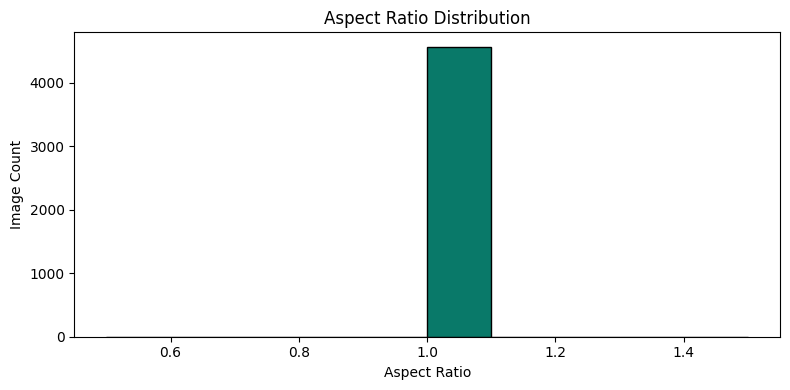

In [11]:
aspect_ratios = []
for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        for image in os.listdir(class_directory):
            i_path = os.path.join(class_directory, 
                                  image)
            image = Image.open(i_path)
            w, h = image.size
            aspect_ratios.append(w/h)

plt.figure(figsize = (8, 4))
plt.hist(aspect_ratios,  
         color = "#097969", 
         edgecolor = "black")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [12]:
resolution = []

for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        for image in os.listdir(class_directory):
            i_path = os.path.join(class_directory, 
                                  image)
            image = Image.open(i_path)
            width, height = image.size
            resolution.append((width, height))

set_resolution = set(resolution)
print(f"Unique resolutions: {set_resolution}")

Unique resolutions: {(224, 224)}


> Based on the aspect ratio plot and unique resolution output, we can conclude that all images in *Dataset2B* share a uniform size of 224×224 pixels.

##### **VARIABILITY CHECK**

In [13]:
def brightness_var(i_path):
    image = np.array(Image.open(i_path).convert("L"))
    mean_brightness = np.mean(image)
    std_brightness = np.std(image)
    return mean_brightness, std_brightness

def occlusion_var(i_path):
    image = np.array(Image.open(i_path).convert("L"))
    t_image = (image > 127).astype(np.uint8) * 255
    white_px = np.sum(t_image == 255)
    occ_percentage = white_px / t_image.size
    return occ_percentage            

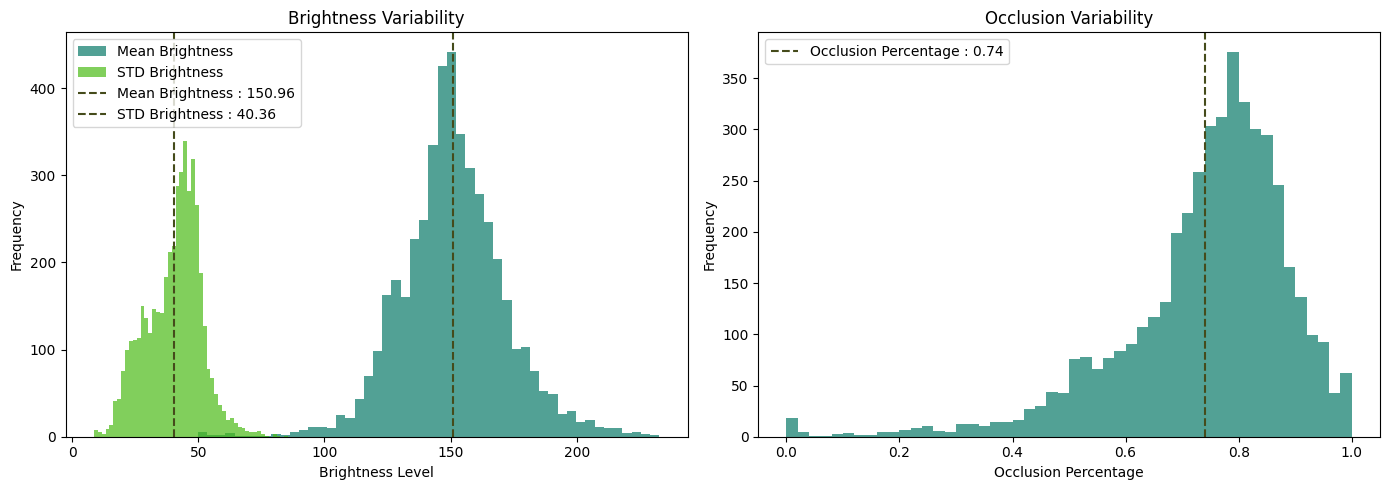

In [14]:
mean_brightness = []
std_brightness = []
occ_percentages = []

for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        for image in os.listdir(class_directory):
            i_path = os.path.join(class_directory, 
                                  image)
            mean_bright, std_bright = brightness_var(i_path)
            mean_brightness.append(mean_bright)
            std_brightness.append(std_bright)
            occ_percentage = occlusion_var(i_path)
            occ_percentages.append(occ_percentage)

plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_brightness, 
         bins = 50, 
         color = "#097969", 
         alpha = 0.7, 
         label = "Mean Brightness")
plt.hist(std_brightness, 
         bins = 50, 
         color = "#4CBB17", 
         alpha = 0.7, 
         label = "STD Brightness")
plt.title("Brightness Variability")
plt.xlabel("Brightness Level")
plt.ylabel("Frequency")
plt.axvline(np.mean(mean_brightness),
            color = "#454B1B",
            linestyle = "--",
            label = f"Mean Brightness : {np.mean(mean_brightness):.2f}")
plt.axvline(np.mean(std_brightness),
            color = "#454B1B",
            linestyle = "--",
            label = f"STD Brightness : {np.mean(std_brightness):.2f}")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(occ_percentages,  
         bins = 50, 
         color = "#097969", 
         alpha = 0.7)
plt.title("Occlusion Variability")
plt.xlabel("Occlusion Percentage")
plt.ylabel("Frequency")
plt.axvline(np.mean(occ_percentages),
            color = "#454B1B",
            linestyle = "--",
            label = f"Occlusion Percentage : {np.mean(occ_percentages):.2f}")
plt.legend()

plt.tight_layout()
plt.show()

> Based on the brightness variability and occlusion variability plots, the following key metrics were observed:
> - Brightness:
>   - Mean: 150.96 (indicating generally bright images)
>   - Standard Deviation: ±40.36 (significant variation in illumination levels across the dataset)
> - Occlusion:
>   - Mean Occlusion Percentage: 74% (high occlusion, suggesting substantial areas of the images are obscured or light-blocked)

##### **IDENTIFY ERROR**

In [15]:
error_found = False
for c_name in os.listdir(train_directory):
    class_directory = os.path.join(train_directory, 
                                   c_name)
    if os.path.isdir(class_directory):
        for image in os.listdir(class_directory):
            i_path = os.path.join(class_directory, 
                                  image)
            try:
                image = Image.open(i_path)
                image.verify()
            except(IOError, SyntaxError):
                print(f"Error at image {i_path} in class {c_name}")
                error_found = True

if error_found == False:
    print("There are no errors.")

There are no errors.


> Based on the code execution above, no corrupted or unreadable images were detected in *Dataset2B*, confirming the dataset is fully functional for processing.

#### **READ AND PREPROCESSING DATA**

In [16]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [17]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

datagen_val = ImageDataGenerator(
    rescale = 1./255
)

datagen_test = ImageDataGenerator(
    rescale = 1./255
)

train_generator = datagen_train.flow_from_directory(
    train_directory,
    target_size = i_size,
    batch_size = b_size,
    class_mode = "sparse",
    color_mode = "rgb",
    seed = SEED
)

val_generator = datagen_val.flow_from_directory(
    val_directory,
    target_size = i_size,
    batch_size = b_size,
    class_mode = "sparse",
    color_mode = "rgb",
    seed = SEED
)

test_generator = datagen_test.flow_from_directory(
    test_directory,
    target_size = i_size,
    batch_size = b_size,
    class_mode = "sparse",
    color_mode = "rgb",
    seed = SEED
)

print("Data successfully read.")

Found 4565 images belonging to 5 classes.
Found 810 images belonging to 5 classes.
Found 586 images belonging to 5 classes.
Data successfully read.


> In this section, I implement [*ImageDataGenerator*](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to load and augment the training data.  
> The purpose of augmentation is to diversify the training samples by applying random rotations, zoom variations, and other spatial transformations.  
> This helps prevent overfitting by exposing the model to more generalized patterns.  
> I normalized validation and test data without augmentation (using rescaling only), using unmodified images to ensure fair performance assessment.

In [18]:
images, labels = next(train_generator)
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: (8, 224, 224, 3)
Shape of labels: (8,)


> The output confirms that the data has been successfully loaded. To verify proper data loading and preprocessing, I'll now visualize sample images from the dataset.

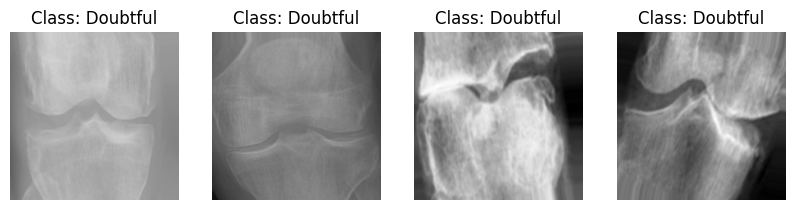

In [19]:
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
plt.figure(figsize = (10, 5))
for i in range(4):
    vis = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])
    c_name = index_to_class[np.argmax(labels[i])]
    plt.title(f"Class: {c_name}")
    plt.axis("off")
plt.show()

> Here, the data has been successfully loaded and can be visualized, so we can proceed to building the CNN model.

#### **MODELLING**

In [20]:
baseline = Sequential([
    Conv2D(96, 
           kernel_size = (11, 11), 
           strides = (4, 4), 
           activation = "relu", 
           input_shape = (224, 224, 3)),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Conv2D(256, 
           kernel_size = (5, 5), 
           activation = "relu", 
           padding = "same"),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Conv2D(384, 
           kernel_size = (3, 3), 
           activation = "relu", 
           padding = "same"),
    Conv2D(384, 
           kernel_size = (3, 3), 
           activation = "relu", 
           padding = "same"),
    Conv2D(256, 
           kernel_size = (3, 3), 
           activation = "relu", 
           padding = "same"),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Flatten(),
    Dense(4096, 
          activation = "relu"),
    Dropout(0.5),
    Dense(4096, 
          activation = "relu"),
    Dropout(0.5),
    Dense(5, 
          activation = "softmax")
])

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [21]:
baseline.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

print("Baseline model compiled.")

Baseline model compiled.


In [22]:
timestamp1 = datetime.now()
history = baseline.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 20,
    validation_data = val_generator,
    validation_steps = len(val_generator),
    verbose = 1
)
timestamp2 = datetime.now()
print(f"Training finished after {(timestamp2 - timestamp1).total_seconds()} seconds.")

Epoch 1/20
571/571 [==============================] - 147s 223ms/step - loss: 1.6104 - accuracy: 0.2004 - val_loss: 1.6089 - val_accuracy: 0.2148
Epoch 2/20
571/571 [==============================] - 127s 223ms/step - loss: 1.6088 - accuracy: 0.2059 - val_loss: 1.6079 - val_accuracy: 0.2148
Epoch 3/20
571/571 [==============================] - 119s 209ms/step - loss: 1.6054 - accuracy: 0.2147 - val_loss: 1.5989 - val_accuracy: 0.2741
Epoch 4/20
571/571 [==============================] - 117s 204ms/step - loss: 1.5894 - accuracy: 0.2502 - val_loss: 1.5367 - val_accuracy: 0.2889
Epoch 5/20
571/571 [==============================] - 128s 224ms/step - loss: 1.4958 - accuracy: 0.3036 - val_loss: 1.4346 - val_accuracy: 0.3309
Epoch 6/20
571/571 [==============================] - 132s 230ms/step - loss: 1.4199 - accuracy: 0.3472 - val_loss: 1.4091 - val_accuracy: 0.3568
Epoch 7/20
571/571 [==============================] - 130s 226ms/step - loss: 1.3458 - accuracy: 0.3864 - val_loss: 1.2833 -

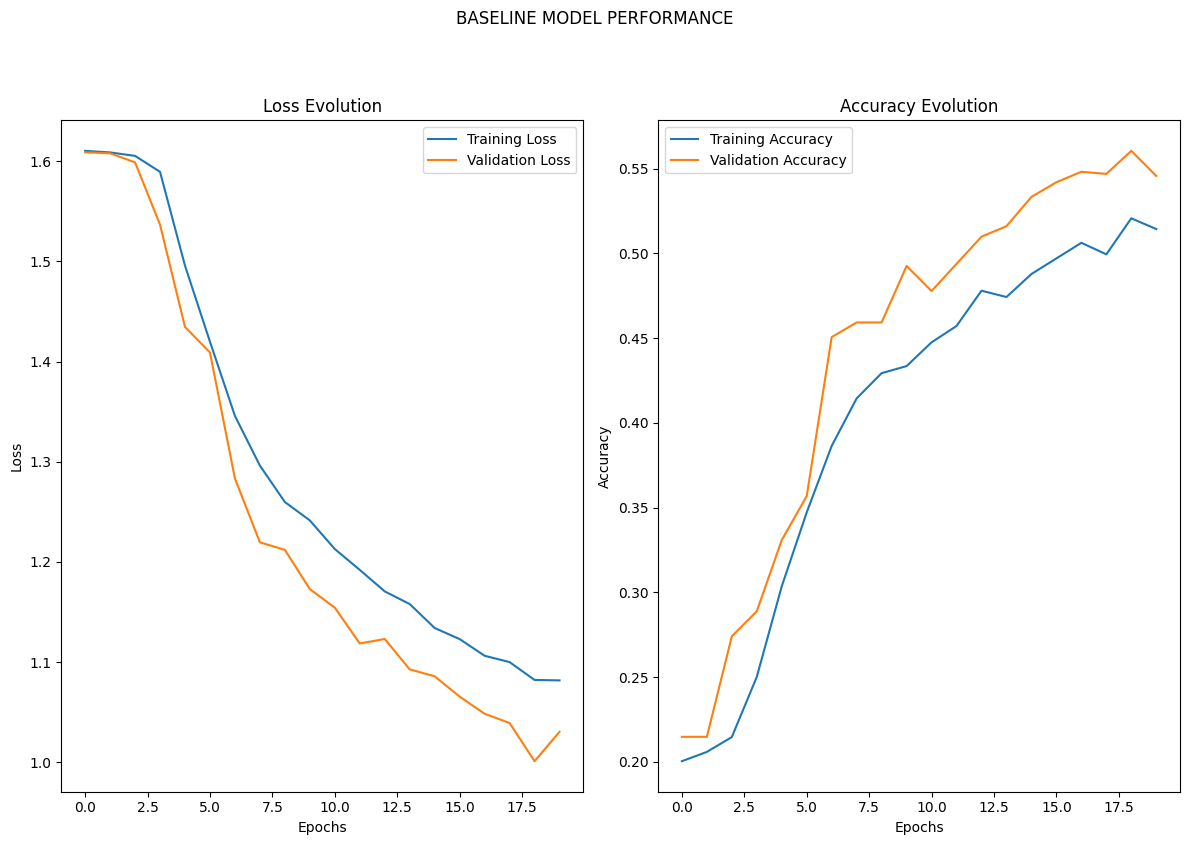

In [23]:
plt.figure(figsize = (12, 8))
plt.suptitle("BASELINE MODEL PERFORMANCE",
             y = 1.05)

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], 
         label = "Training Loss")
plt.plot(history.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], 
         label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], 
         label = "Validation Accuracy")
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

> Based on the baseline model performance plot above, it is observed that my baseline AlexNet model has a loss of 1.08 and an accuracy of 0.51, with a validation loss of 1.03 and validation accuracy of 0.54 at the 20th epoch.  
> The difference of around 0.05 in loss and 0.03 in accuracy indicates that the model is not experiencing symptoms of overfitting, as the gap between training and validation performance is relatively small.  
> However, the loss value of 1.08 suggests that the model has not sufficiently converged in learning the data patterns, while the accuracy of 0.51 implies that the model is somewhat gambling in predicting the target.  
> This may be due to an insufficient number of epochs, leading to suboptimal training, a model that lacks complexity either structurally or functionally, or because the image data used is of low quality.

#### **MODIFY MODEL**

In [24]:
callback = [
    ModelCheckpoint(
        filepath = "best_model.h5",
        save_best_only = True,
        monitor = "val_loss",
        mode = "min"
    ),
    EarlyStopping(
        monitor = "val_loss",
        patience = 3,
        restore_best_weights = True
    ),
    ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 2,
        min_lr = 1e-6
    )
]

> In the code above, I prepared callbacks to be used as parameters in the modified model later on.  
> The types of callbacks I used are:  
> - [*ModelCheckpoint*](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint), which is used to save the best model during the training process; here, I save the model with the lowest val_loss.
> - [*EarlyStopping*](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping), which is used to stop the training process early if the val_loss does not improve after 3 epochs, in order to prevent overfitting.
> - [*ReduceLROnPlateau*](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau), which is used to automatically reduce the learning rate if the val_loss does not decrease after 2 epochs.  
> 
> Therefore, these three types of callbacks are used with the main goal of avoiding overfitting and achieving optimal val_loss and accuracy values.

In [25]:
modified = Sequential([
    Conv2D(96, 
           kernel_size = (11, 11), 
           strides = (4, 4),
           input_shape = (224, 224, 3)),
    LeakyReLU(alpha = 0.1),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Conv2D(256, 
           kernel_size = (5, 5),  
           padding = "same"),
    LeakyReLU(alpha = 0.1),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Conv2D(384, 
           kernel_size = (3, 3), 
           padding = "same"),
    LeakyReLU(alpha = 0.1),
    Conv2D(384, 
           kernel_size = (3, 3), 
           padding = "same"),
    LeakyReLU(alpha = 0.1),
    Conv2D(256, 
           kernel_size = (3, 3), 
           padding = "same"),
    LeakyReLU(alpha = 0.1),
    MaxPooling2D((3, 3),
                 strides = (2, 2)),
    Flatten(),
    Dense(4096),
    LeakyReLU(alpha = 0.1),
    Dropout(0.2),
    Dense(4096),
    LeakyReLU(alpha = 0.1),
    Dropout(0.3),
    Dense(5, 
          activation = "softmax")
])

modified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 26, 26, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                  

> In this modified model, I retained the number of layers, but I changed the activation function to [*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) to test my initial assumption that the poor loss and accuracy values in the baseline model were due to a lack of model complexity.  
> In addition, I also adjusted the [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) values in several layers of this model, which are used to randomly deactivate neurons in order to prevent overfitting and enhance the model’s ability to generalize.

In [26]:
modified.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

print("Modified model compiled.")

Modified model compiled.


In [27]:
timestamp1 = datetime.now()
history_m = modified.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 30,
    validation_data = val_generator,
    validation_steps = len(val_generator),
    verbose = 1,
    callbacks = callback
)
timestamp2 = datetime.now()
print(f"Training finished after {(timestamp2 - timestamp1).total_seconds()} seconds.")

Epoch 1/30
571/571 [==============================] - 136s 234ms/step - loss: 1.6097 - accuracy: 0.2085 - val_loss: 1.6072 - val_accuracy: 0.2148 - lr: 1.0000e-05
Epoch 2/30
571/571 [==============================] - 131s 230ms/step - loss: 1.6024 - accuracy: 0.2272 - val_loss: 1.5745 - val_accuracy: 0.2642 - lr: 1.0000e-05
Epoch 3/30
571/571 [==============================] - 131s 228ms/step - loss: 1.5307 - accuracy: 0.2786 - val_loss: 1.4838 - val_accuracy: 0.3148 - lr: 1.0000e-05
Epoch 4/30
571/571 [==============================] - 130s 227ms/step - loss: 1.4256 - accuracy: 0.3474 - val_loss: 1.3899 - val_accuracy: 0.3691 - lr: 1.0000e-05
Epoch 5/30
571/571 [==============================] - 133s 233ms/step - loss: 1.3565 - accuracy: 0.3820 - val_loss: 1.2683 - val_accuracy: 0.4123 - lr: 1.0000e-05
Epoch 6/30
571/571 [==============================] - 132s 231ms/step - loss: 1.2949 - accuracy: 0.4193 - val_loss: 1.2485 - val_accuracy: 0.4222 - lr: 1.0000e-05
Epoch 7/30
571/571 [==

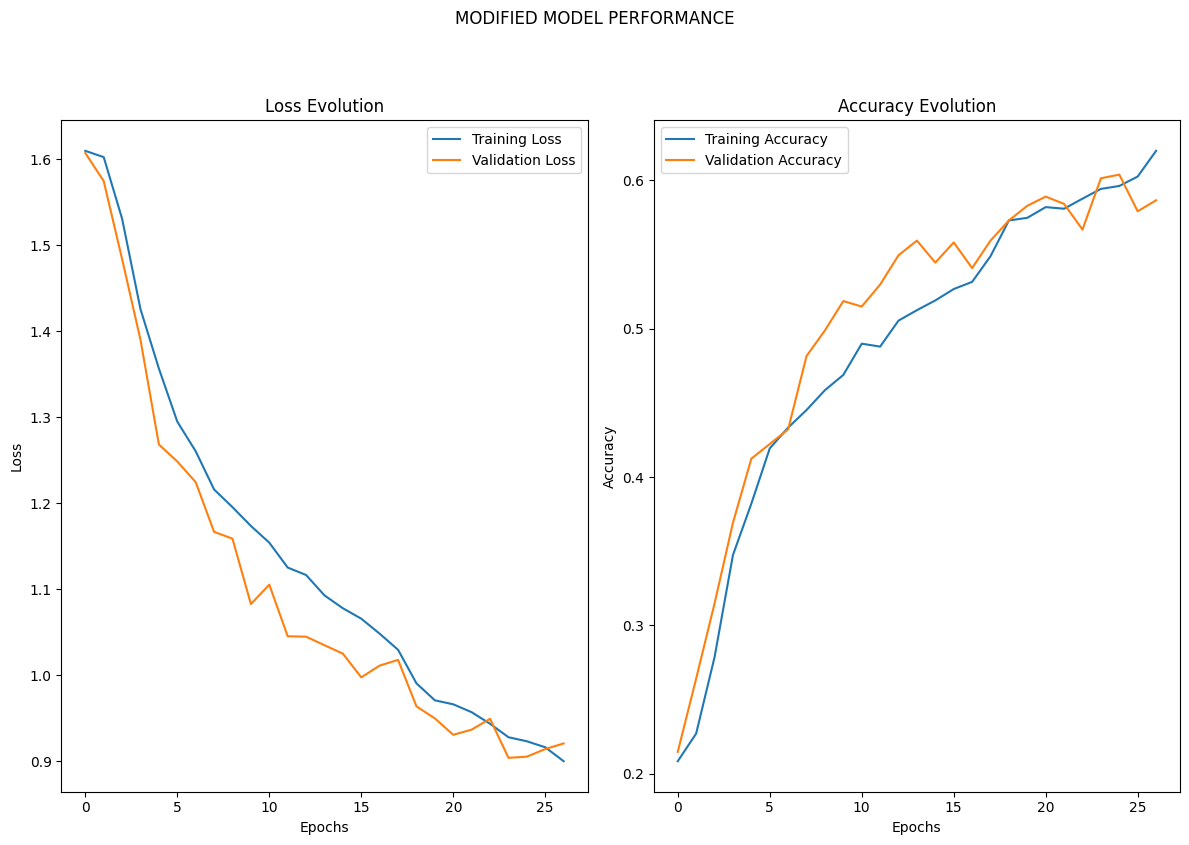

In [28]:
plt.figure(figsize = (12, 8))
plt.suptitle("MODIFIED MODEL PERFORMANCE",
             y = 1.05)

plt.subplot(1, 2, 1)
plt.plot(history_m.history["loss"], 
         label = "Training Loss")
plt.plot(history_m.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_m.history["accuracy"], 
         label = "Training Accuracy")
plt.plot(history_m.history["val_accuracy"], 
         label = "Validation Accuracy")
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

> Based on the results of the modified model above, the training loss value of 0.90 and validation loss value of 0.92 indicate increased stability and a reduction in prediction error compared to the baseline model.  
> Additionally, the accuracy of 0.62 and validation accuracy of 0.59 suggest that the model performs better in predicting the data more accurately, although it is still not yet optimal.  
> This supports my initial assumption that the poor accuracy of the model could be due to the insufficient functional complexity of the model in learning patterns from the data. Thus, when the activation function was changed to [*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU), which is more resistant to the dead neurons problem, along with adjustments to the number of dropout layers, the model's performance improved.  
> Nevertheless, the performance of this model still needs to be tested and further evaluated using testing data to verify and assess the model's generalization ability.

#### **MODEL EVALUATION**

##### **BASELINE MODEL EVALUATION**

74/74 [==============================] - 9s 126ms/step - loss: 1.2305 - accuracy: 0.4334
Test Accuracy : 0.43344709277153015
74/74 [==============================] - 4s 43ms/step
              precision    recall  f1-score   support

    Doubtful       0.20      0.37      0.26       117
        Mild       0.28      0.23      0.25       117
    Moderate       0.22      0.22      0.22       117
      Normal       0.12      0.04      0.06       118
      Severe       0.21      0.20      0.20       117

    accuracy                           0.21       586
   macro avg       0.20      0.21      0.20       586
weighted avg       0.20      0.21      0.20       586

1/1 [==============================] - 0s 277ms/step
Predicted classes: [0 2 0 2 0]
True classes: [1. 2. 3. 2. 1.]


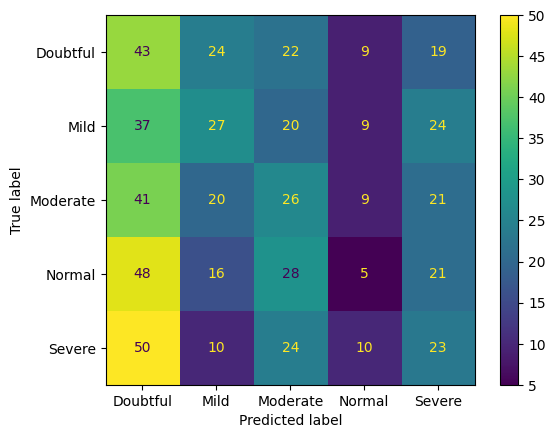

In [29]:
test_generator.reset()
test_loss, test_acc = baseline.evaluate(test_generator)
print(f"Test Accuracy : {test_acc}")

test_generator.reset()
y_true = test_generator.classes
predictions = baseline.predict(test_generator,
                               steps = len(test_generator))
y_pred = np.argmax(predictions,
                   axis = 1)
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names = class_names))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names).plot()

test_generator.reset()
x_batch, y_batch = next(test_generator)
prediction_batch = baseline.predict(x_batch[:5])
prediction_class = np.argmax(prediction_batch, 
                             axis = 1)
print(f"Predicted classes: {prediction_class}")
print(f"True classes: {y_batch[:5].flatten()}")

> Based on the classification report and confusion matrix above, it can be concluded that the baseline AlexNet model has an accuracy of 21%, indicating a serious issue with the model’s generalization ability and a high likelihood of overfitting, especially since the  [training dan validation](#Part-B) accuracy values in Part B are much higher than the testing accuracy.

> A general evaluation of the classification report:
> - A precision value of 0.2 or 20% indicates that only 20% of all predictions were actually correct, with the model struggling the most in predicting the Normal class — only 12% of predictions labeled Normal were truly from the Normal class.
> - A recall of 21% shows that only 21% of the actual data instances were correctly identified, with the lowest recall in the Normal class at only 0.04.
> - As a harmonic mean of precision and recall, the f1-score also reflects that the model is still far from ideal.

> As seen in the confusion matrix:
> - Doubtful has 43 true positives and 74 false negatives.
> - Mild has 27 true positives and 90 false negatives.
> - Moderate has 26 true positives and 91 false negatives.
> - Normal has 5 true positives and 113 false negatives.
> - Severe has 23 true positives and 94 false negatives.

> Based on the evaluation of all five classes, the predictions for every class are poor, with significantly more false negatives than true positives. This means the model’s performance is very weak and uninformative.

##### **MODIFIED MODEL EVALUATION**

74/74 [==============================] - 3s 35ms/step - loss: 1.1404 - accuracy: 0.4863
Test Accuracy : 0.48634812235832214
74/74 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

    Doubtful       0.17      0.15      0.16       117
        Mild       0.12      0.05      0.07       117
    Moderate       0.20      0.30      0.24       117
      Normal       0.19      0.22      0.21       118
      Severe       0.25      0.26      0.25       117

    accuracy                           0.20       586
   macro avg       0.19      0.20      0.19       586
weighted avg       0.19      0.20      0.19       586

1/1 [==============================] - 0s 298ms/step
Predicted classes: [3 3 3 1 2]
True classes: [3. 0. 3. 1. 2.]


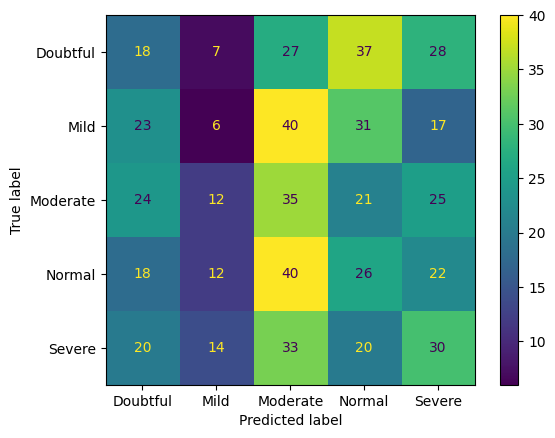

In [30]:
test_generator.reset()
test_loss_m, test_acc_m = modified.evaluate(test_generator)
print(f"Test Accuracy : {test_acc_m}")

test_generator.reset()
y_true = test_generator.classes
predictions_m = modified.predict(test_generator,
                                 steps = len(test_generator))
y_pred_m = np.argmax(predictions_m,
                     axis = 1)
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_m, target_names = class_names))

cm = confusion_matrix(y_true, y_pred_m)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names).plot()

test_generator.reset()
x_batch_m, y_batch_m = next(test_generator)
prediction_batch_m = modified.predict(x_batch_m[:5])
prediction_class_m = np.argmax(prediction_batch_m, 
                               axis = 1)
print(f"Predicted classes: {prediction_class_m}")
print(f"True classes: {y_batch_m[:5].flatten()}")

> Based on the classification report and confusion matrix above, it can be concluded that the modified AlexNet model has an accuracy of 20%, indicating that this model performs worse than the baseline model. It even shows signs of overfitting, given that the [training dan validation](#Part-C) accuracy in Part C are significantly higher than the testing accuracy.

> A general evaluation of the classification report:
> - A precision value of 0.19 or 19% indicates that only 19% of all predictions were actually correct, with the model struggling the most in predicting the Mild class — only 12% of the predictions labeled Mild were truly from that class.
> - A recall of 20% shows that only 20% of the actual instances in the dataset were correctly predicted, with the lowest recall again in the Mild class, at just 0.05.
> - As a combination of precision and recall, the f1-score confirms that the model is still far from ideal.

> From the confusion matrix:
> - Doubtful has 18 true positives and 99 false negatives.
> - Mild has 6 true positives and 111 false negatives.
> - Moderate has 35 true positives and 82 false negatives.
> - Normal has 26 true positives and 92 false negatives.
> - Severe has 30 true positives and 87 false negatives.

> Based on the evaluation across all five classes, the model’s predictions are also very poor, with the number of false negatives far outweighing the true positives.  
> Therefore, the modified model has failed to improve the performance of the baseline model — in fact, it has made it worse.

> Based on both evaluations, it is evident that changes in the activation function or modifications to the dropout layers did not produce a significant impact, as both models performed equally poorly in predicting the data.  
> Therefore, it can be assumed that the main cause of the low accuracy is not due to the model's structural or functional complexity, but rather the poor quality of the data being input into the model.  
> Based on the results of the occlusion variability exploration conducted earlier, it was found that many images have a high degree of occlusion, with an average of 0.74. This means that the majority of objects in the images are covered or obstructed by other elements, which directly affects the model’s prediction accuracy.